### things we can try to experiment with:

- linkage

- distance metric

- adding connectivity constraints

### from scikit-learn's docs on clustering

- First clustering with a connectivity matrix is much faster.

- Second, when using a connectivity matrix, average and complete linkage are unstable and tend to create a few clusters that grow very quickly. 

In [1]:
import csv
import os
import pickle
import re
import sys

import matplotlib.pyplot as plt
import numpy as np

from joblib import Parallel, delayed

from difflib import SequenceMatcher,get_close_matches

from scipy import spatial
from scipy.cluster.hierarchy import dendrogram, linkage

from tqdm import *

module_path = os.path.abspath(os.path.join('../helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)

# my stuff in the helpers/ directory
import embeddings_helper, files_helper, texts_helper, metrics_helper, tags_helper, cobrinha_helper

from cobrinha_helper import get_metrics_for_tag_pair

In [2]:
PICKLE_ROOT = "/media/felipe/SSD_VOLUME//auto-tagger/data/tag-hierarchy/"

tag_vocabulary = pickle.load(open(PICKLE_ROOT+"tag_vocabulary.p","rb"))
tag_vectors_index = pickle.load(open(PICKLE_ROOT+"tag_vectors_index.p","rb"))
global_similarity_index = pickle.load(open(PICKLE_ROOT+"global_similarity_index.p","rb"))
sorted_pairwise_similarity_dict = pickle.load(open(PICKLE_ROOT+"sorted_pairwise_similarity_dict.p","rb"))

In [3]:
tag_vectors_index['sql']

array([ 13.31756595,   1.2150911 ,   0.30977384, ...,   0.        ,
         0.        ,   0.        ])

In [4]:
tag_vectors_as_list = list()

for key, value in tag_vectors_index.items():
    tag_vectors_as_list.append((key,value))
   
ordered_tag_vectors = sorted(tag_vectors_as_list, key= lambda tpl: tpl[0])    

In [5]:
points = list()
labels = list()

for key,value in ordered_tag_vectors:
    points.append(value)
    labels.append(key)
    
TAG_VECTORS = np.vstack(points)

TAG_VECTORS.shape

(618, 4692)

In [6]:
labels[:10]

['.htaccess',
 '.net',
 '.net-4.0',
 '3d',
 'access-vba',
 'actionscript-3',
 'active-directory',
 'activerecord',
 'ajax',
 'algorithm']

In [7]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

generate dummy data (radial)

In [8]:
# Generate sample data
# http://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.htmln_samples = 1500
np.random.seed(0)
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

### plot structured ward-linkage cluster using a scatter plot (dummy radial data)

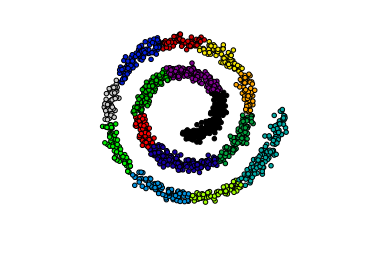

In [9]:
plt.clf()

graph = kneighbors_graph(X, 30, include_self=False)

model = AgglomerativeClustering(linkage='ward',
                                            connectivity=graph,
                                            n_clusters=15)

model.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=model.labels_,cmap=plt.cm.spectral)
plt.axis('equal')
plt.axis('off')
plt.show()

### plot unstructured ward-linkage cluster using scipy's linkage + dendrogram (dummy radial data)

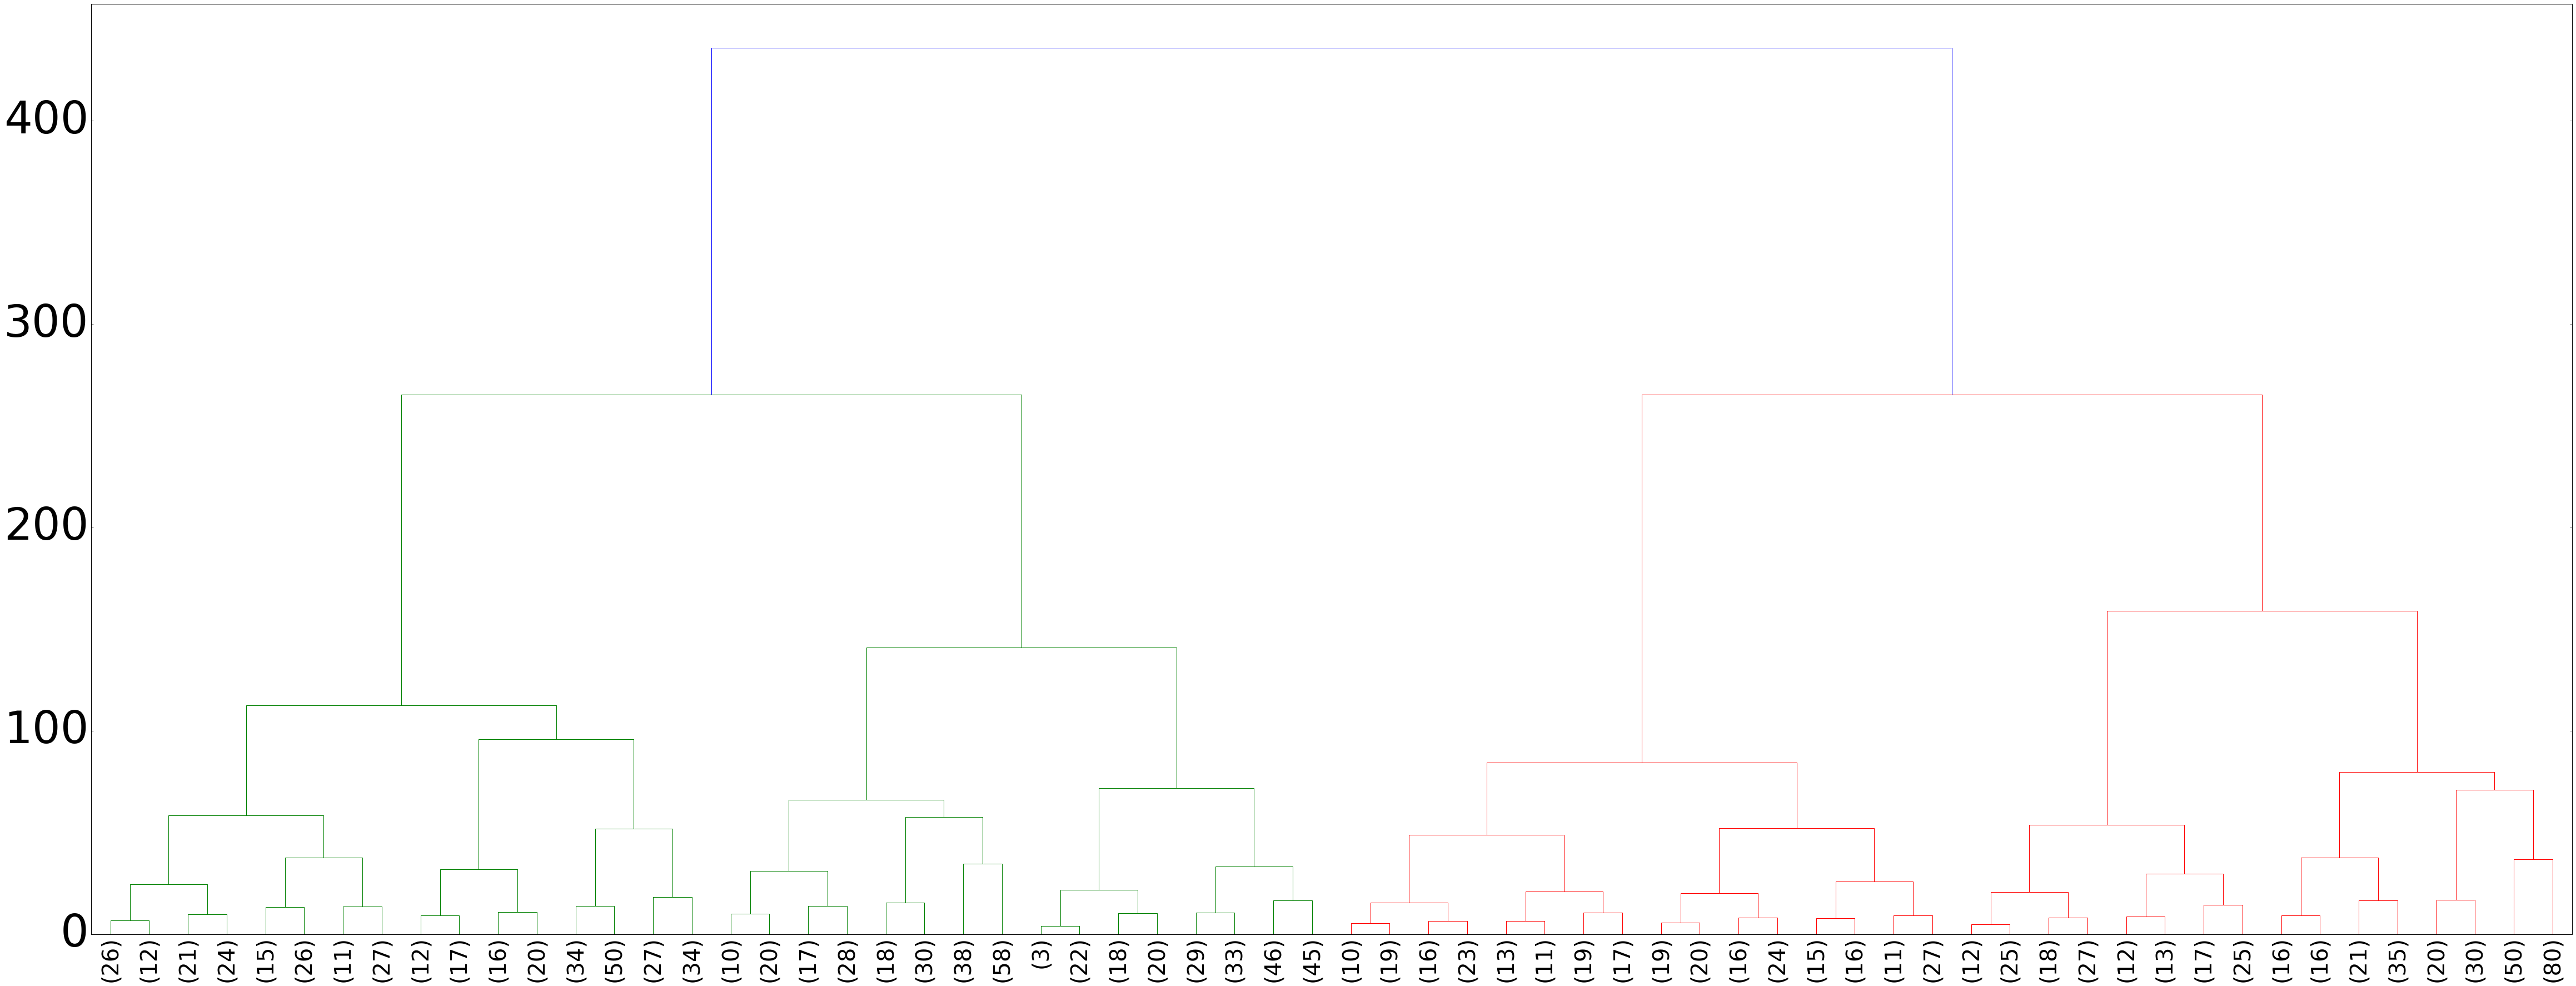

In [10]:
W=80
H=30
P=5
TRUNCATE_MODE='level'
LINKAGE='ward' # 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'
FONT_SIZE = 40
METRIC='euclidean' # 'euclidean', 'minkowski', 'cityblock', 'cosine' (and others...)

plt.clf()
plt.figure(figsize=(W,H))

Z = linkage(X,LINKAGE,metric=METRIC)

# dn = dendrogram(Z,labels=labels,truncate_mode=TRUNCATE_MODE,p=P,leaf_font_size=FONT_SIZE)
dn = dendrogram(Z,truncate_mode=TRUNCATE_MODE,p=P,leaf_font_size=FONT_SIZE)
fig = plt.gcf()

ax = plt.gca()

ax.tick_params(axis='x', which='major', labelsize=FONT_SIZE)
ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE*2)

plt.show()

# fig.savefig("dendrograms/dummy-data/{}-{}-{}-{}.svg".format(LINKAGE,TRUNCATE_MODE,P,METRIC), format='svg')

### plot unstructured ward-linkage cluster using sklearn's agglomerative clustering + scipy dendrogram hack (dummy radial data)

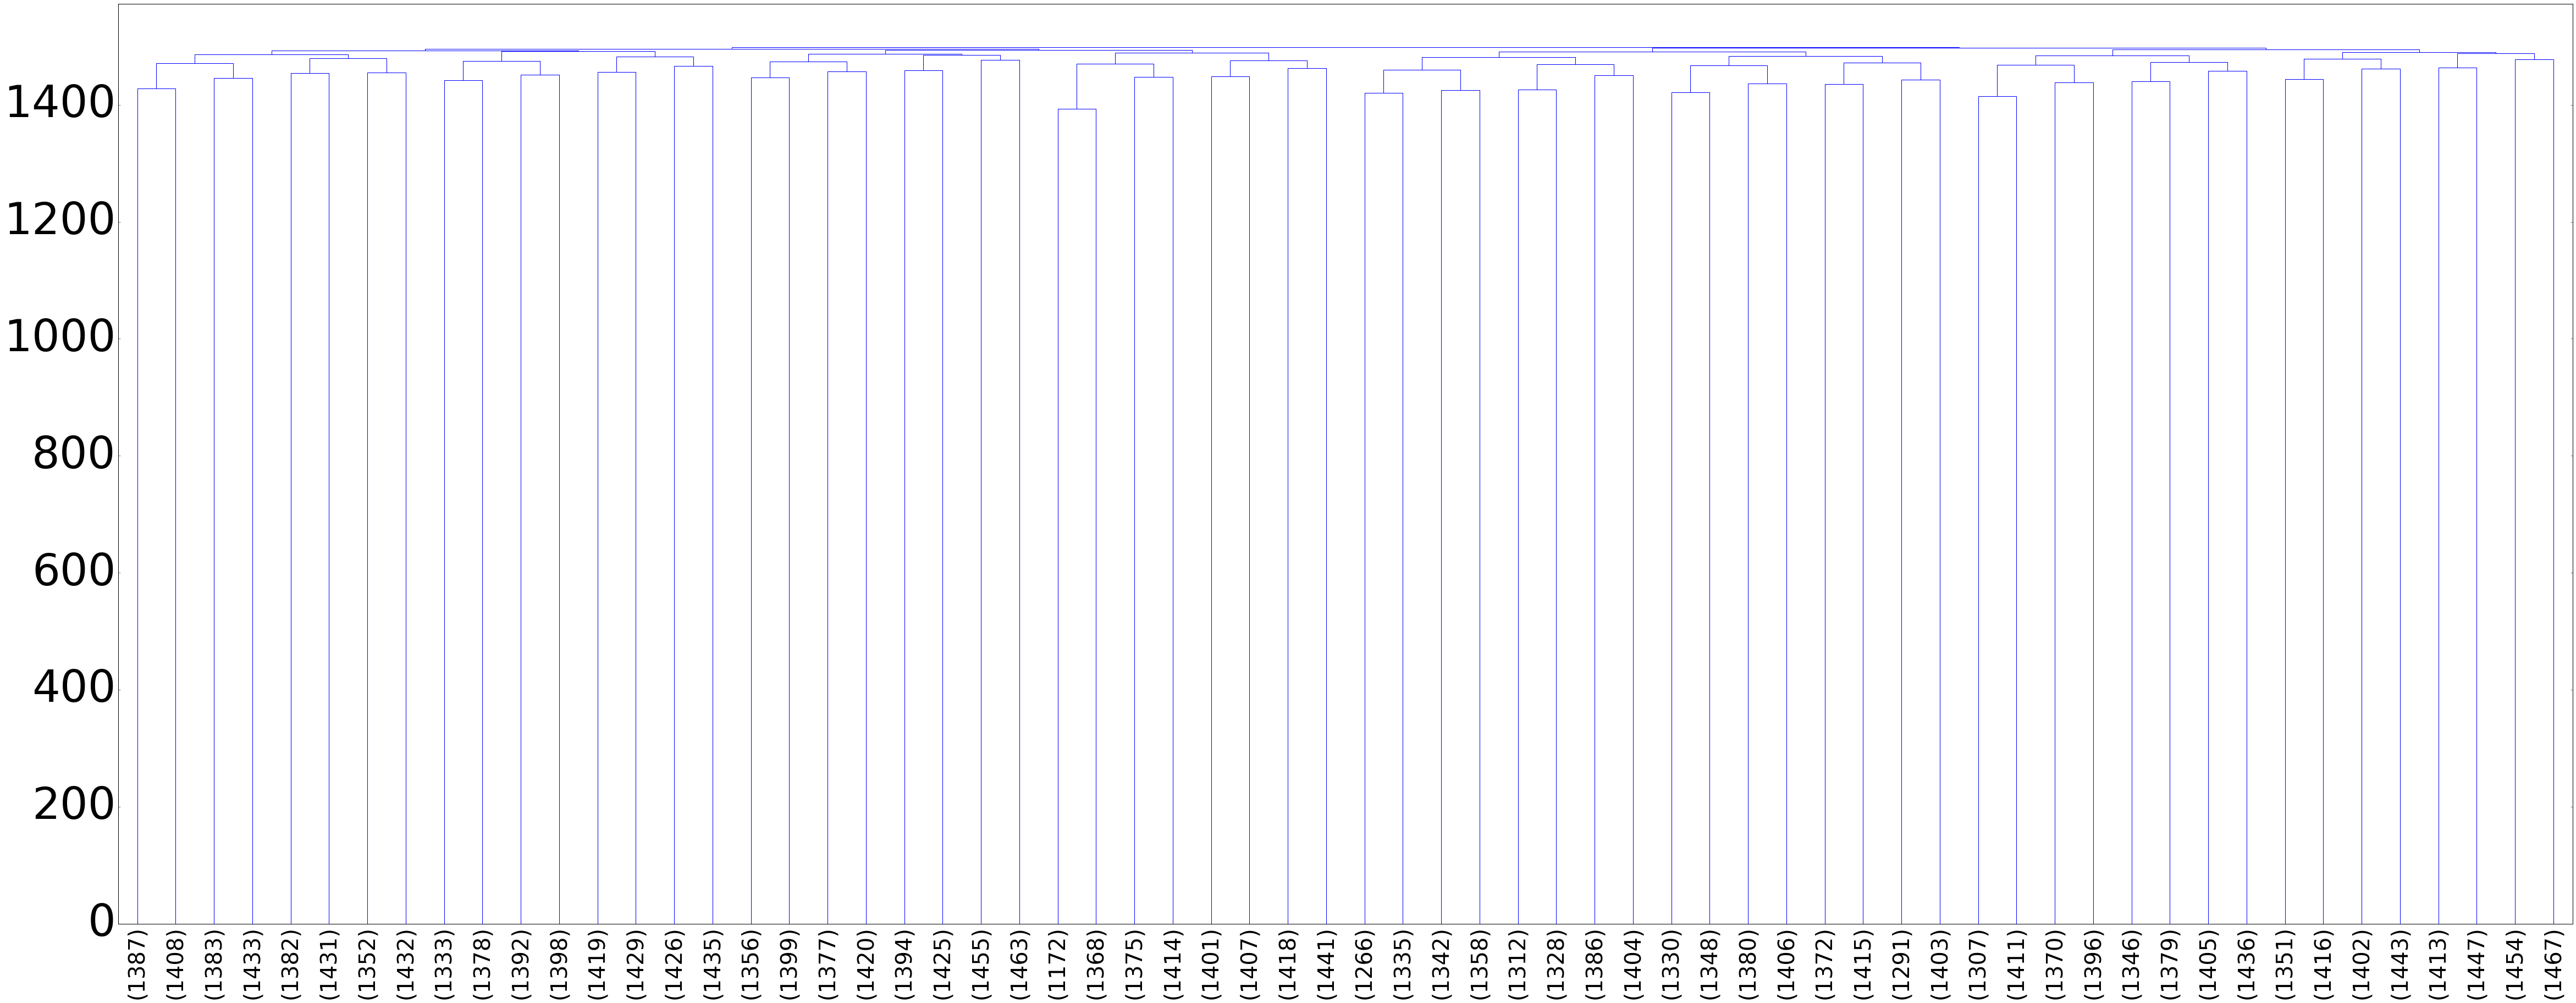

In [11]:
plt.clf()

plt.figure(figsize=(W,H))

model = AgglomerativeClustering(linkage=LINKAGE,
                                affinity=METRIC)

model.fit(X)

distance = np.arange(model.children_.shape[0])
position = np.arange(2, model.children_.shape[0]+2)

linkage_matrix = np.column_stack([
    model.children_, distance, position]
).astype(float)

dn = dendrogram(linkage_matrix,truncate_mode=TRUNCATE_MODE,p=P,leaf_font_size=FONT_SIZE)
fig = plt.gcf()

ax = plt.gca()

ax.tick_params(axis='x', which='major', labelsize=FONT_SIZE)
ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE*2)

plt.show()

are the linkage matrices generated by both methods the same?

In [12]:
# the first 2 columns are the same
print(np.allclose(Z[:,0],linkage_matrix[:,0]))
print(np.allclose(Z[:,1],linkage_matrix[:,1]))

# but the last 2 columns of the linkage matrix are not
print(np.allclose(Z[:,2],linkage_matrix[:,2]))
print(np.allclose(Z[:,3],linkage_matrix[:,3]))

True
True
False
False


### plot unstructured ward-linkage cluster using scipy's linkage + dendrogram (tag-vectors data)

In [13]:
# leave this cell here to use as a template

W=50
H=30
P=10
TRUNCATE_MODE='level'
LINKAGE='ward' # 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'
FONT_SIZE = 15
METRIC='euclidean' # 'euclidean', 'minkowski', 'cityblock', 'cosine' (and others...)

plt.figure(figsize=(W,H))

Z = linkage(TAG_VECTORS,LINKAGE,metric=METRIC)

# https://stackoverflow.com/a/40559070/436721
with plt.rc_context({'lines.linewidth':1.5}):
    dn = dendrogram(Z,labels=labels,truncate_mode=TRUNCATE_MODE,p=P)

fig = plt.gcf()

ax = plt.gca()

dn = dendrogram(Z,labels=labels,truncate_mode=TRUNCATE_MODE,p=P)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis='x', which='major', labelsize=FONT_SIZE)
ax.tick_params(axis='y', which='major', labelsize=30)

fig.savefig("dendrograms/tag-vectors/{}-{}-{}.svg".format(LINKAGE,TRUNCATE_MODE,P,METRIC), format='svg')